In [0]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
np.random.seed(0)
from statistics import mean

今回はアルゴリズムの評価が中心の章なので,学習アルゴリズム実装は後に回し、sklearnを学習アルゴリズムとして使用する。

In [0]:
import sklearn

今回、学習に使うデータはsin関数に正規分布$N(\varepsilon|0,0.05)$ノイズ項を加えたデータを使う

In [0]:
size = 100
max_degree = 11
x_data = np.random.rand(size) * np.pi * 2
var_data = np.random.normal(loc=0,scale=0.1,size=size)
sin_data = np.sin(x_data) + var_data

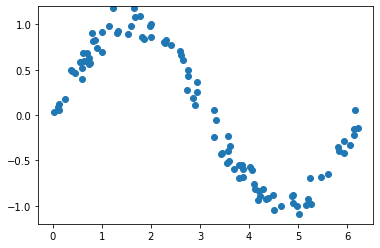

In [0]:
plt.ylim(-1.2,1.2)
plt.scatter(x_data,sin_data)


学習用のアルゴリズムは多項式回帰を使います。

In [0]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline

2.2.2:**MSE**:近似の良さの評価手法。

$$MSE=\int (y(x;D) - h(x))^2p(x)dx=E\{(y(x;D)-h(x))^2\}$$

In [0]:
def MSE(y,t):
  return np.sum(np.square(y-t))/y.size

In [0]:
MSE(np.array([10,3,3]),np.array([1,2,3]))

27.333333333333332

2.2.1 (1)**ホールドアウト法**:
手元のデータを2つに分割し、片方をトレーニングに使い、片方をテストに使う手法。
テストデータの数が必要

In [0]:
%%time
def holdout_method(x,y,per=0.8,value_func=MSE,degree=11):
  index = np.random.permutation(x.size)
  index_train,index_test = np.split(index,[int(x.size*per)])
  #plt.scatter(x_data[index_train],sin_data[index_train])
  test_score_list = []
  train_score_list = []
  for i in range(1,degree):
    pf = PolynomialFeatures(degree=i, include_bias=False)
    lr = LinearRegression()
    pl = Pipeline([("PF", pf), ("LR", lr)])
    pl.fit(x[index_train].reshape(-1,1), y[index_train])

    pred_y_test = pl.predict(x[index_test].reshape(-1,1))
    pred_y_train = pl.predict(x[index_train].reshape(-1,1))
    score_train = value_func(pred_y_train,y[index_train])
    score_test = value_func(pred_y_test,y[index_test])
    train_score_list.append(score_train)
    test_score_list.append(score_test)

  return train_score_list,test_score_list

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 15 µs


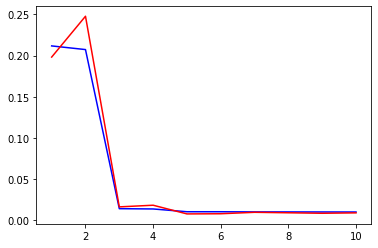

In [0]:
hold_train_score_list,hold_test_score_list = holdout_method(x_data,sin_data,degree=max_degree)
plt.plot(np.array(range(1,max_degree)),np.array(hold_train_score_list),color='b')
plt.plot(np.array(range(1,max_degree)),np.array(hold_test_score_list),color='r')

(2)**交差確認法**:手元の各クラスをn分割して、n-1のグループで学習して、残りの１つのグループのデータでテストをし、その平均を誤り率とした性能評価を行う。

In [0]:
def cross_validation(x,y,value_func=MSE,split_num=5,degree=1):
  assert x.size % split_num==0,"You must use divisible number"
  n = x.size / split_num
  train_scores =[]
  test_scores =[]
  for i in range(split_num):
    indices = [int(i*n),int(i*n+n)]
    train_x_1,test_x,train_x_2=np.split(x,indices)
    train_y_1,test_y,train_y_2=np.split(y,indices)

    train_x = np.concatenate([train_x_1,train_x_2])
    train_y = np.concatenate([train_y_1,train_y_2])
    
    pf = PolynomialFeatures(degree=degree, include_bias=False)
    lr = LinearRegression()
    pl = Pipeline([("PF", pf), ("LR", lr)])
    pl.fit(train_x.reshape(-1,1), train_y)

    pred_y_test = pl.predict(np.array(test_x).reshape(-1,1))
    pred_y_train = pl.predict(np.array(train_x).reshape(-1,1))

    score_train = value_func(pred_y_train,train_y)
    #print(score_train)
    score_test = value_func(pred_y_test,test_y)
    #print(len(test_y))
    train_scores.append(score_train)
    test_scores.append(score_test)

  return mean(train_scores),mean(test_scores)

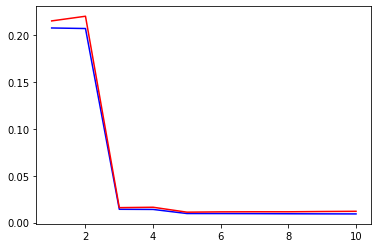

In [0]:
cross_test_score_list = []
cross_train_score_list = []
for i in range(1,max_degree):
  tra,tes = cross_validation(x_data,sin_data,degree=i)
  cross_train_score_list.append(tra)
  cross_test_score_list.append(tes)
plt.plot(np.array(range(1,max_degree)),np.array(cross_train_score_list),color='b')
plt.plot(np.array(range(1,max_degree)),np.array(cross_test_score_list),color='r')

(3)**一つ抜き法**:交差確認法の特別な場合で、データ数＝グループの数としたものである。

In [0]:
def leave_one_out(x,y,value_func=MSE,size=size,degree=1):
  return cross_validation(x,y,value_func,split_num=size,degree=degree)

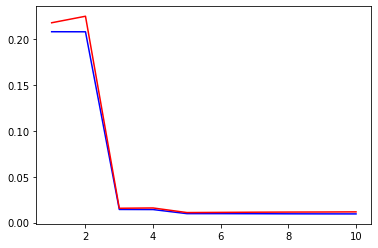

In [0]:
leave_test_score_list = []
leave_train_score_list = []
for i in range(1,max_degree):
  tra,tes = leave_one_out(x_data,sin_data,degree=i)
  leave_train_score_list.append(tra)
  leave_test_score_list.append(tes)
plt.plot(np.array(range(1,max_degree)),np.array(leave_train_score_list),color='b')
plt.plot(np.array(range(1,max_degree)),np.array(leave_test_score_list),color='r')

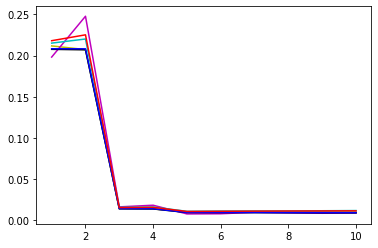

In [0]:
plt.plot(np.array(range(1,max_degree)),np.array(hold_train_score_list),color='y')
plt.plot(np.array(range(1,max_degree)),np.array(hold_test_score_list),color='m')

plt.plot(np.array(range(1,max_degree)),np.array(cross_train_score_list),color='k')
plt.plot(np.array(range(1,max_degree)),np.array(cross_test_score_list),color='c')

plt.plot(np.array(range(1,max_degree)),np.array(leave_train_score_list),color='b')
plt.plot(np.array(range(1,max_degree)),np.array(leave_test_score_list),color='r')

(4)**ブートストラップ法**:N個の復元抽出をしてブートストラップサンプルを作り、そこから

$bias=\varepsilon(N^*,N^*)-N(N^*,N)$
を推定して、それをいくつか計算してその平均でバイアスを推定する。
その推定値を$\overline{bias}$として、その推定値を

$\varepsilon = \varepsilon(N,N)-\overline{bias}$
とする。

In [0]:
def bootstrap(x,y,value_func=MSE,trial=50,degree=1):
  biases=[]
  for i in range(trial):
    boot_ind = np.random.choice(range(x.size),size=x.size,replace=True)
    pf = PolynomialFeatures(degree=degree, include_bias=False)
    lr = LinearRegression()
    pl = Pipeline([("PF", pf), ("LR", lr)])
    pl.fit(x[boot_ind].reshape(-1,1), y[boot_ind])

    pred_y_boot = pl.predict(x[boot_ind].reshape(-1,1))
    pred_y_base = pl.predict(x.reshape(-1,1))

    score_boot = value_func(pred_y_boot,y[boot_ind])
    #print(score_train)
    score_base = value_func(pred_y_base,y)
    bias = score_base - score_boot
    #print(bias)
    biases.append(bias)

  pf = PolynomialFeatures(degree=degree, include_bias=False)
  lr = LinearRegression()
  pl = Pipeline([("PF", pf), ("LR", lr)])
  pl.fit(x.reshape(-1,1), y)

  pred_y_base = pl.predict(x.reshape(-1,1))
  score_base = value_func(pred_y_base,y)
  return score_base + mean(biases)

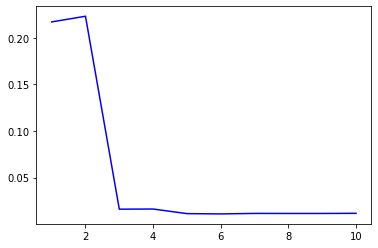

In [0]:
boot_score_list = []
for i in range(1,max_degree):
  boot_score = bootstrap(x_data,sin_data,degree=i)
  boot_score_list.append(boot_score)
plt.plot(np.array(range(1,max_degree)),np.array(boot_score_list),color='b')